<h3>Story Level Analysis - CivicDataLabs</h3> <br>
Problem statement: Using language processing techniques, analyse how the complexity of language changes across levels of the story. <a href="https://gitlab.civicdatalab.in/civicdatalab/pratham-books-story-level-analysis/tree/master">Link</a>

Given a deceptively simple problem statement and a dataset of story books in three different languages, we will explore the dataset and try to understand what makes a story suitable for proficient readers as opposed to beginner or someone who is learning to read.
A rough breakdown of what we will be doing in sequence:
1. Cleaning data
2. Light Exploratory data analysis
3. Extracting features based on general understanding and more technical aspects
4. Testing feature effectiveness
5. Improvise. Adapt. Overcome.

In [1]:
# Imports
import re
from copy import copy

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import textstat
import regex

from confusion_matrix_pretty_print import plot_confusion_matrix_from_data

In [64]:
data_path = "data/stories.csv"
data = pd.read_csv(data_path)

data.columns

Index(['Unnamed: 0', 'story_id', 'title', 'english_title',
       'reading_level_updated', 'story_langugage', 'synopsis', 'content',
       'category_name', 'tag_name', 'story_original_title'],
      dtype='object')

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3697 entries, 0 to 3696
Data columns (total 11 columns):
Unnamed: 0               3697 non-null int64
story_id                 3697 non-null int64
title                    3697 non-null object
english_title            1745 non-null object
reading_level_updated    3697 non-null object
story_langugage          3697 non-null object
synopsis                 3697 non-null object
content                  3640 non-null object
category_name            3697 non-null object
tag_name                 2605 non-null object
story_original_title     3640 non-null object
dtypes: int64(2), object(9)
memory usage: 317.8+ KB


In [54]:
data.head()

,Unnamed: 0,story_id,title,english_title,reading_level_updated,story_langugage,synopsis,content,category_name,tag_name,story_original_title
0,0,1,वह हँस दिया,Veh Hans Diyaa,L1,Hindi,क्‍या आपको दौड़ लगाने में मज़ा आता है? हमारी कहा...,Kitchenvadoekdiscl ClothesT-hemp&nbsp;&nbsp;&n...,"Fiction, Family & Friends, Animal Stories",NaN,वह हँस दिया
1,1,2,Smile Please!,Smile Please!,L1,English,Follow the young deer as he races along with f...,A fawn was racing in the forest. He was ahead ...,"Fiction, Family & Friends, Animal Stories, Ani...",NaN,वह हँस दिया
2,5,7,Fat King Thin Dog,Fat King Thin Dog,L1,English,Run along with the Fat King after the Thin Dog!,This is a fat king. The fat king has a thin do...,"Fiction, Funny, Animal Stories",NaN,Fat King Thin Dog
3,6,8,मोटा राजा दुबला कुत्ता,Mota Raja Dubla Kutta,L1,Hindi,मोटे राजा के साथ दुबले कुत्ते के पीछे भागिये!\r\n,यह है मोटा राजा। मोटे राजा का है दुबला कुत्ता...,"Fiction, Funny, Animal Stories, Animal Stories...",NaN,Fat King Thin Dog
4,14,16,"Vayu, the Wind","Vayu, the Wind",L2,English,A nice story about this silent and always pres...,"Everytime I finish my hot, hot bath,My wet bod...","Science & Nature, Poems, Poems, Science & Nature",NaN,वारा


<h3>1. Cleaning data</h3>
<ul>
<li>With some initial metadata of the dataset, we can see that the columns 'tag_name' is sparse compared to rest of the columns and 'story_id' and 'unnamed_0' dont serve any purpose to us now. Its interesting to notice that the column 'content' has less non-null rows than rows in total. If there are story with no content for us to analyze, we can safely discard those rows after finding out if there is something more to it than just missing data.</li>

<li>We will first look at the rows where 'content' is null. We check with 'story_id' if the story has been misplaced or repeated twice, once with content and once without content or to find some other data gathering problem.</li>

<li>Also 'category_name' is of type object(str) and it could be useful later on to have it processed and present as a list of string items. </li>

<li>Another problem is with the 'content' in row zero, with multiple '&-nbsp;', which doesnt seem to have been removed. These seems to have escaped the clean_html functionality of some of the package (which I have verified) so we will remove it manually.</li>
</ul>

In [55]:
data[data.content.isnull()].head()

,Unnamed: 0,story_id,title,english_title,reading_level_updated,story_langugage,synopsis,content,category_name,tag_name,story_original_title
449,1026,2874,Maya - Story of Us,NaN,L3,English,This is the story of a young princess who uses...,NaN,"Adventure & Mystery, Fiction, Growing Up, Play...",NaN,Maya - Story of Us
770,1629,6304,My Hair,NaN,L1,English,"The monstrous comb, the tic-tac clip and the s...",NaN,"Family & Friends, Fiction, Funny, Lifeskills, ...",NaN,My Hair
780,1642,6394,What if?,NaN,L1,English,We are one happy lot - hacking trees for our c...,NaN,Fiction,nature,What if?
876,1806,7141,"Do good,get good",NaN,L1,English,Gooodness returns goodness,NaN,"Fantasy, Wordless Stories","good, Fishes, Wordless Stories","Do good,get good"
1032,2354,9425,Tall story - Two headed lion,NaN,L2,English,Once upon a time in a jungle lived a two-heade...,NaN,"Animal Stories, Fantasy, Fiction","Tall story - Two headed lion, Aliya",Tall story - Two headed lion


In [56]:
data[data['story_id']==2874]

,Unnamed: 0,story_id,title,english_title,reading_level_updated,story_langugage,synopsis,content,category_name,tag_name,story_original_title
449,1026,2874,Maya - Story of Us,NaN,L3,English,This is the story of a young princess who uses...,NaN,"Adventure & Mystery, Fiction, Growing Up, Play...",NaN,Maya - Story of Us


With the above output we can see that the story id is not duplicated and the content is indeed NaN. After verifying that missing content rows are indeed just holes in data, we will remove the unnecessary rows and columns. We will follow up by converting 'category_name' string to usable list and cleaning the noise words in the story content by using Python's internal regex package 're'.

In [2]:
#
#
# Remove later
#
#
data_path = "data/stories.csv"
data = pd.read_csv(data_path)

data = data[data.content.notnull()]

data = data.drop(['Unnamed: 0', 'story_id', 'tag_name'], axis=1)

data['category_name'] = data['category_name'].str.lower()
data['category_name'] = data['category_name'].str.split(',')

In [81]:
# Function to remove manually some of the text content 
def clean_nbsp(text):
    new_text = re.sub('(&nbsp;)+', ' ', text)
    new_text = re.sub('(\n)+', '', new_text)
    new_text = re.subn('(\t)+', '', new_text)
    # mistake 
    new_text = ''.join([word for word in new_text[0] if word.isalpha() or word==" "])
    return new_text.lstrip(" ").lstrip("\t").rstrip(" ").rstrip("\t")

before_text = copy(data['content'][0])

data['content'] = data['content'].apply(clean_nbsp)

after_text = data['content'][0]

,title,english_title,reading_level_updated,story_langugage,synopsis,content,category_name,story_original_title
0,वह हँस दिया,Veh Hans Diyaa,L1,Hindi,क्‍या आपको दौड़ लगाने में मज़ा आता है? हमारी कहा...,Kitchenvadoekdiscl ClothesThemp Kortbroek da...,"[fiction, family & friends, animal stories]",वह हँस दिया
1,Smile Please!,Smile Please!,L1,English,Follow the young deer as he races along with f...,A fawn was racing in the forest He was ahead o...,"[fiction, family & friends, animal stories, ...",वह हँस दिया


In [84]:
print(before_text, end="\n\n")
print(after_text)

Kitchenvadoekdiscl ClothesT-hemp&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Kortbroek&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; das &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Kouse &nbsp; &nbsp;&nbsp; Baadjie&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Nagklere&nbsp;&nbsp;&nbsp; onderklereT-shirt&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; shorts&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; tie&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; socks&nbsp;&nbsp;&nbsp;&nbsp; jacket&nbsp;&nbsp;&nbsp; pajamasisikipha&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ibhulukhwe&nbsp;&nbsp;&nbsp; iqhina﻿&nbsp;&nbsp;&nbsp; iikawusi&nbsp; ibhatyi&nbsp;&nbsp; ipijama ClothesT-hemp&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Kortbroek&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; das &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Kouse &nbsp; &nbsp;&nbsp; Baadjie&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; NagklereT-shirt&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; shorts&nbsp;&nbsp;&nbsp;&nbsp;&nbs

Our before and after text reveals two problems:
1. There are unnecessary text in english in between story content that is supposed to be in Hindi
2. The Hindi part of the story is totally wrong from before!

The problem here is that the Python idiom we used to remove special character from text seems to misbehave for Hindi characters. Here the code has stripped all vowels succeding any consonant for Hindi characters and I suspect the same thing must be happening with Telugu characters.
<i>Sometimes it is important to document mistakes and this is a prime example of such times because when working with unknown languages, such bugs are highly unlikely to be caught with ease. </i>

In [95]:
# Running faulty code to highlight mistake
sample_hindi_text = "यह है मोटा राजा।  मोटे राजा का है दुबला कुत्ता। मोटा राजा व दुबला कुत्ता घूमने निकले।  दुबले कुत्ते ने चिड़िया देखी। वह उसके पीछे भागा।  मोटा राजा दुबले कुत्ते के पीछे भागा।  दोनों भागे। और कई दिनों तक भागते रहे!  मोटे राजा ने दुबले कुत्ते को पकड़ ही लिया।  मोटा राजा अब दुबला है!"
output = ''.join([w for w in sample_hindi_text if w.isalpha() or w==" "])
print(sample_hindi_text, "\n\n", output)

यह है मोटा राजा।  मोटे राजा का है दुबला कुत्ता। मोटा राजा व दुबला कुत्ता घूमने निकले।  दुबले कुत्ते ने चिड़िया देखी। वह उसके पीछे भागा।  मोटा राजा दुबले कुत्ते के पीछे भागा।  दोनों भागे। और कई दिनों तक भागते रहे!  मोटे राजा ने दुबले कुत्ते को पकड़ ही लिया।  मोटा राजा अब दुबला है! 

 यह ह मट रज  मट रज क ह दबल कतत मट रज व दबल कतत घमन नकल  दबल कतत न चड़य दख वह उसक पछ भग  मट रज दबल कतत क पछ भग  दन भग और कई दन तक भगत रह  मट रज न दबल कतत क पकड़ ह लय  मट रज अब दबल ह


Let's rewrite the function to take into consideration:<br>
a. content language - If its English, only keep English characters and similarly for Hindi and Telugu.<br>
b. content punctuation - Unlike how we did it before, we want to keep characters like period and exclamation mark which can come in useful later.<br>
<br>
We will achieve this by using Unicode character block and a python package called 'regex'.<br>

In [98]:
sample_hindi_text = "यह है मोटा राजा।  Kitchenvadoekdiscl ClothesThemp  Kortbroek  das           Kouse     Baadjie    Nagklere  onderklereTshirt  shorts  tie  socks  jacket  pajamasisikipha  ibhulukhwe  iqhina  iikawusi  ibhatyi  ipijama ClothesThemp  Kortbroek  das           Kouse     Baadjie    NagklereTshirt  shorts  tie  socks  jacket isikipha  ibhulukhwe  iqhina  iikawusi  ibhatyi ClothesThemp  Kortbroek  das           Kouse     Bमोटे राजा का है दुबला कुत्ता। मोटा राजा व दुबला कुत्ता घूमने निकले।  दुबले कुत्ते ने चिड़िया देखी। वह उसके पीछे भागा।  मोटा राजा दुबले कुत्ते के पीछे भागा।  दोनों भागे। और कई दिनों तक भागते रहे!  मोटे राजा ने दुबले कुत्ते को पकड़ ही लिया।  मोटा राजा अब दुबला है!"
# Devnagiri unicode character block for Hindi characters
output = regex.sub(u"[^ \r\n\p{Devanagari}.।?!\-]", "", sample_hindi_text)
output = regex.sub(' +',' ', output)

print(sample_hindi_text, "\n\n", output)
# Voila!

यह है मोटा राजा।  Kitchenvadoekdiscl ClothesThemp  Kortbroek  das           Kouse     Baadjie    Nagklere  onderklereTshirt  shorts  tie  socks  jacket  pajamasisikipha  ibhulukhwe  iqhina  iikawusi  ibhatyi  ipijama ClothesThemp  Kortbroek  das           Kouse     Baadjie    NagklereTshirt  shorts  tie  socks  jacket isikipha  ibhulukhwe  iqhina  iikawusi  ibhatyi ClothesThemp  Kortbroek  das           Kouse     Bमोटे राजा का है दुबला कुत्ता। मोटा राजा व दुबला कुत्ता घूमने निकले।  दुबले कुत्ते ने चिड़िया देखी। वह उसके पीछे भागा।  मोटा राजा दुबले कुत्ते के पीछे भागा।  दोनों भागे। और कई दिनों तक भागते रहे!  मोटे राजा ने दुबले कुत्ते को पकड़ ही लिया।  मोटा राजा अब दुबला है! 

 यह है मोटा राजा। मोटे राजा का है दुबला कुत्ता। मोटा राजा व दुबला कुत्ता घूमने निकले। दुबले कुत्ते ने चिड़िया देखी। वह उसके पीछे भागा। मोटा राजा दुबले कुत्ते के पीछे भागा। दोनों भागे। और कई दिनों तक भागते रहे! मोटे राजा ने दुबले कुत्ते को पकड़ ही लिया। मोटा राजा अब दुबला है!


In [3]:
def clean_content(row):
    new_text = regex.sub('(&nbsp;)+', ' ', row['content'])
    new_text = regex.sub('(\n)+', '', new_text)
    new_text = regex.sub('(\t)+', '', new_text)
    if row['story_langugage'] == 'English':
        new_text = regex.sub(u"[^ \r\n\p{Basic Latin}]", "", new_text)
    elif row['story_langugage'] == 'Hindi':
        new_text = regex.sub(u"[^ \r\n\p{Devanagari}.।?!]", "", new_text)
    elif row['story_langugage'] == 'Telugu':
        new_text = regex.sub(u"[^ \r\n\p{Telugu}.?!\-]", "", new_text)
    new_text = regex.sub(' +',' ', new_text)
    return new_text.lstrip(" ").rstrip(" ")

before_text = copy(data['content'][0])

data['content'] = data.apply(clean_content, axis=1)

after_text = data['content'][0]

print("Before cleaning: ", before_text, "\n\n\n", "After cleaning:", after_text)

Before cleaning:  Kitchenvadoekdiscl ClothesT-hemp&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Kortbroek&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; das &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Kouse &nbsp; &nbsp;&nbsp; Baadjie&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Nagklere&nbsp;&nbsp;&nbsp; onderklereT-shirt&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; shorts&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; tie&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; socks&nbsp;&nbsp;&nbsp;&nbsp; jacket&nbsp;&nbsp;&nbsp; pajamasisikipha&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ibhulukhwe&nbsp;&nbsp;&nbsp; iqhina﻿&nbsp;&nbsp;&nbsp; iikawusi&nbsp; ibhatyi&nbsp;&nbsp; ipijama ClothesT-hemp&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Kortbroek&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; das &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; Kouse &nbsp; &nbsp;&nbsp; Baadjie&nbsp; &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; NagklereT-shirt&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; shorts&nbsp;&nbs

With this we finish data cleaning section.

<h3>2. Exploratory data analysis</h3>

<p>Here we will plot some bar charts to see the distribution of reading levels across story language and category of story.</p>

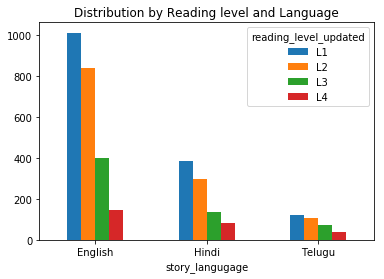

In [288]:
data.groupby(['story_langugage','reading_level_updated'])['content'].count().unstack().plot(kind='bar', title="Distribution by Reading level and Language", rot=360)

In [301]:
data_category = data.set_index(['reading_level_updated', 'story_langugage'])['category_name'].apply(pd.Series).stack()
data_category = data_category.reset_index()
data_category.columns = ['reading_level','story_language', 'uid', 'category']
# If you want to plot

data_category_groups = data_category.groupby(['category','reading_level'])['uid'].count().unstack().fillna(0)
data_category_groups['Total'] = data_category_groups.sum(axis=1)
data_category_groups.loc['Total']= data_category_groups.sum()
data_category_groups

reading_level,L1,L2,L3,L4,Total
category,,,,,
activity books,14.0,11.0,0.0,0.0,25.0
adventure & mystery,10.0,18.0,16.0,12.0,56.0
animal stories,122.0,136.0,47.0,31.0,336.0
biographies,4.0,10.0,5.0,3.0,22.0
family & friends,294.0,310.0,114.0,67.0,785.0
fantasy,51.0,101.0,50.0,23.0,225.0
fiction,467.0,443.0,188.0,89.0,1187.0
flashcards,39.0,6.0,1.0,0.0,46.0
folktales & myths,13.0,34.0,26.0,14.0,87.0


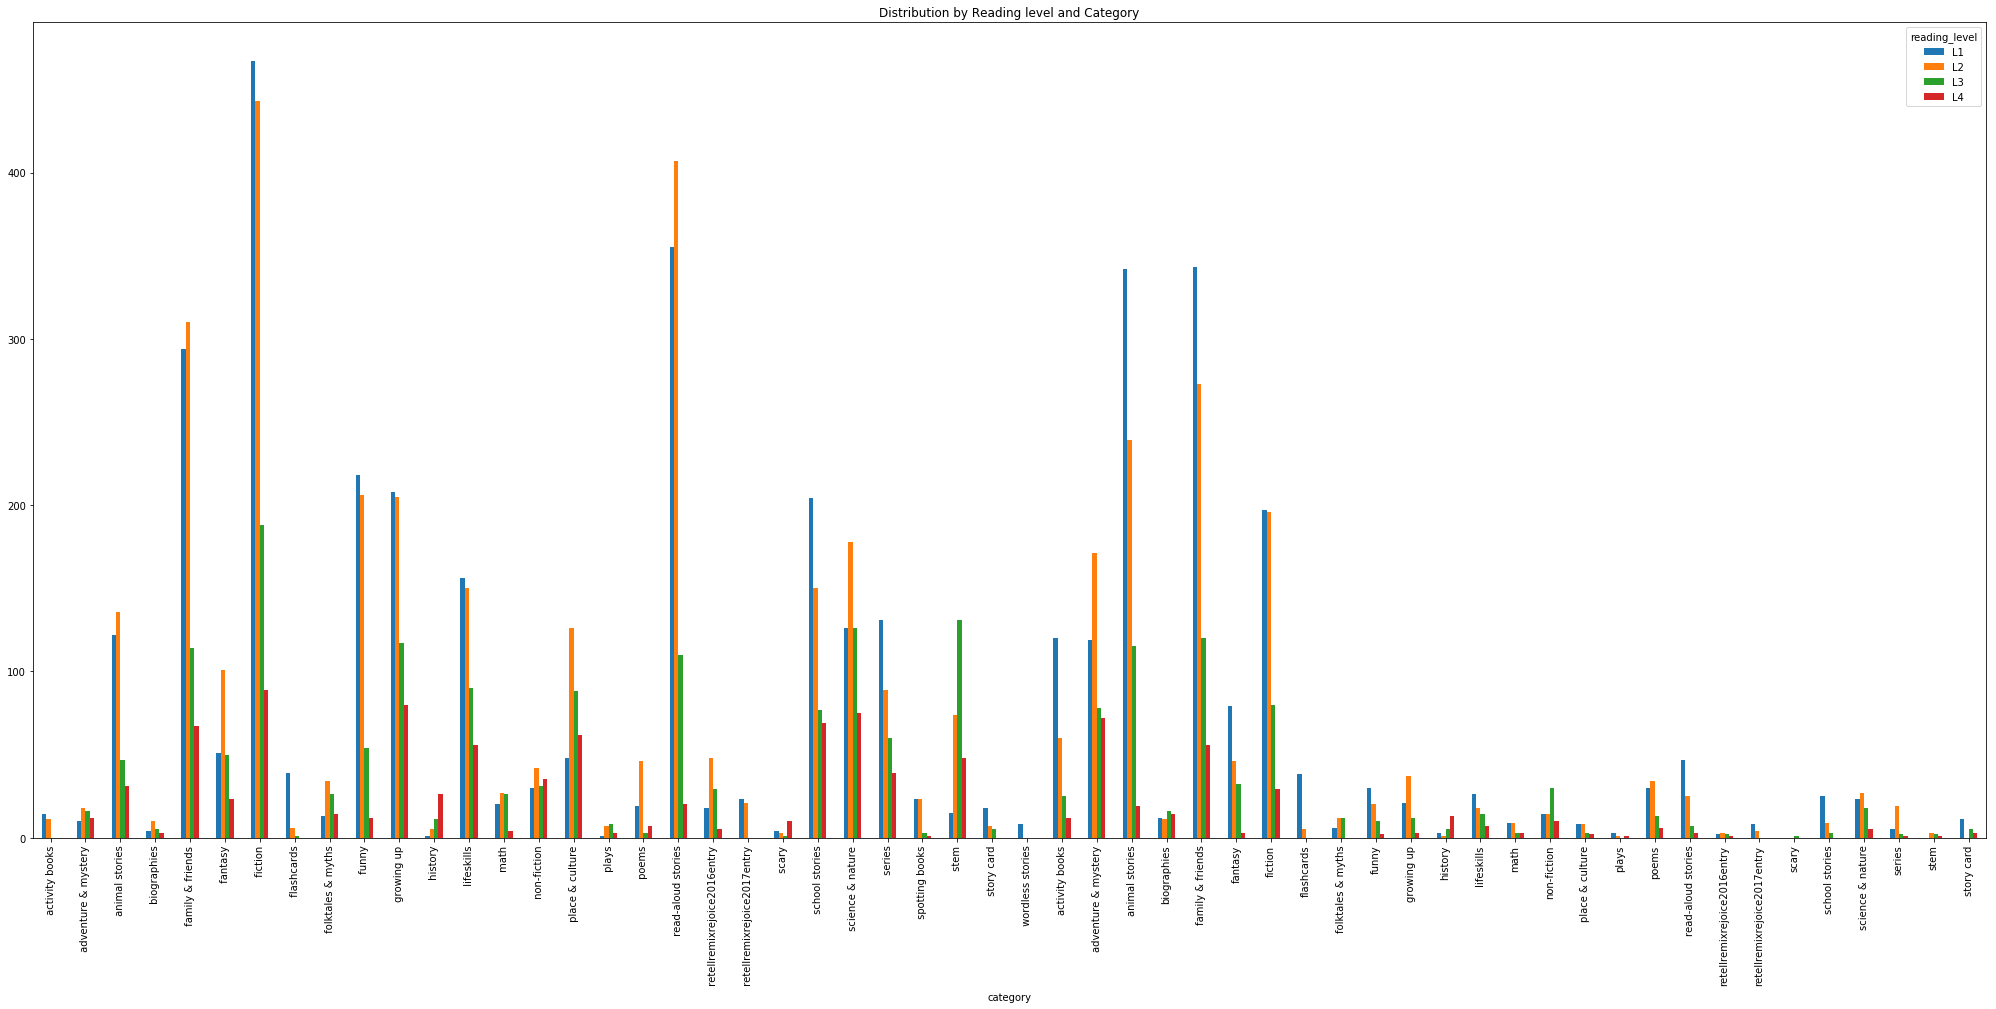

In [290]:
data_category.groupby(['category','reading_level'])['uid'].count().unstack().plot(kind='bar', title="Distribution by Reading level and Category", figsize=(35,15))

Even if it was 'exploratory' data analysis, we had an objective in mind. Following are the observations with respect to out objective:
<ul>
    <li>Reading levels distribution seems to be consistent across languages.</li>
    <li>Very less anomaly is seen in category of story to relate to reading levels. We were looking for some categories where L3 and L4 content is much more in count than L1 and L2. Except for minor exceptions, category has not showm major impact in reading levels.</li>
    <li>Another kind of exploration namely internet exploration led to a pretty solid description of what to expect from reading levels - https://storyweaver.org.in/reading_levels. We will keep this in mind for the feature extraction phase.</li>
</ul>

<h3>3. Feature extraction</h3>
<p>We will formulate this problem as a classification problem and look for features in the data. This would allow us to probe further on reading levels. Extracting statistical features would help us to understand the underlying data regardless of the language of data and it will help in ruling out bias. For testing the significance of our features, we will use a random forest classifier to quickly see how good the prediction of reading levels are given the features. One important note on how it would differentiate from a general machine learning modelling: We will not try to improve the model in any way, no stacking or boosting or hyperparameter optimization i.e. the only improvement that will come to the model is with better features.</p>
<p>These selection of features are what I call token based features. Here tokens are an individual unit of the content; a word per se. </p>
<ul>
    <li>No. of words in story - Every token separated by space is considered a word</li>
    <li>No. of unique words in story - Total of every unique token in story counted once</li>
    <li>No. of sentences in story - Count of collection of tokens separated by period(.) in English and Telugu or separated by Devnagiri danda(|) in Hindi</li>
    <li>Avg. TF-IDF of story - For each word in story, calculate Term frequency * Inverse Document Frequency. Term Frequency (TF) and Unverse Document Frequency (IDF) are features generally used in Information Retrieval. TF score provides the importance of a word in a given document with a rationale that more a term is repeated in that document, more importance it carries. IDF score provides the importance of a word for the entire corpus. Sometimes common words like "the", "and" are repeated too often and are repeated in most of the document. IDF score effectively reduces the importance of such documents and highlights truly unique and important word for each document. More info about the formula can be found here on wiki.
        <ul>
            <li>Rationale for using TF-IDF: <br> One thing I noticed while reading the stories is that the as the reading level increases, assumption of prior knowledge increases. This assumption is clearly evident in explanation of some concept in the story. In lower reading levels, explanation is kept simple, both with less words and by using well known/ beginner friendly words. While explanation in higher reading levels would give lesser known or lesser frequently used words, which the reader might not be acquinted with. This I think can be captured effectively with TF-IDF. Any language model can also be used for this and we should try using a word2vec model of these languages to score the reading content based on frequency of words in a larger corpus. </li>
        </ul>
    </li>
</ul>

In [23]:
def count_unique_words(row):
    text = row['content'].lower().split(" ")
    return (len(text),len(set(text)))

data[['story_word_count', 'story_unique_word_count']] = data.apply(count_unique_words, axis=1, result_type="expand")

# In English and telugu, end of sentence is denote by '.'(period). In hindi end of sentence is denoted by '|' (devnagiri danda - unicode: u"\u0964")  
data.loc[data['story_langugage'] == 'Hindi', 'story_sentence_count'] = data[data['story_langugage'] == 'Hindi']['content'].str.split(u"\u0964").str.len()
data.loc[data['story_langugage'] != 'Hindi', 'story_sentence_count'] = data[data['story_langugage'] != 'Hindi']['content'].str.split('.').str.len()
data = data.fillna(0)

In [9]:


for lang in ["English", "Hindi", "Telugu"]:
    corpus = data[data['story_langugage'] == lang]['content']
    vectorizer = TfidfVectorizer(ngram_range = (1,1), use_idf = True)
    tfidf_matrix = vect.fit_transform(corpus)
    #idf_matrix = vectorizer.idf_
    #print(idf_matrix.shape)
    # Mean
    data.loc[data['story_langugage'] == lang, 'tfidf_avg'] = np.true_divide(tfidf_matrix.sum(1), (tfidf_matrix!=0).sum(1)+1)
    #data.loc[data['story_langugage'] == lang, 'idf_avg'] = np.true_divide(idf_matrix.sum(1), (idf_matrix!=0).sum(1)+1)

data.head(5)

,title,english_title,reading_level_updated,story_langugage,synopsis,content,category_name,story_original_title,tfidf_avg
0,वह हँस दिया,Veh Hans Diyaa,L1,Hindi,क्‍या आपको दौड़ लगाने में मज़ा आता है? हमारी कहा...,माँ आयीं। बोलीं लो पत्थर को मार दिया। हिरण का ...,"[fiction, family & friends, animal stories]",वह हँस दिया,0.248443
1,Smile Please!,Smile Please!,L1,English,Follow the young deer as he races along with f...,A fawn was racing in the forest. He was ahead ...,"[fiction, family & friends, animal stories, ...",वह हँस दिया,0.088609
2,Fat King Thin Dog,Fat King Thin Dog,L1,English,Run along with the Fat King after the Thin Dog!,This is a fat king. The fat king has a thin do...,"[fiction, funny, animal stories]",Fat King Thin Dog,0.148641
3,मोटा राजा दुबला कुत्ता,Mota Raja Dubla Kutta,L1,Hindi,मोटे राजा के साथ दुबले कुत्ते के पीछे भागिये!\r\n,यह है मोटा राजा। मोटे राजा का है दुबला कुत्ता।...,"[fiction, funny, animal stories, animal sto...",Fat King Thin Dog,0.153476
4,"Vayu, the Wind","Vayu, the Wind",L2,English,A nice story about this silent and always pres...,"Everytime I finish my hot, hot bath,My wet bod...","[science & nature, poems, poems, science & ...",वारा,0.063620


In [25]:
# Category label encoding for story levels and language

data['story_langugage'] = data['story_langugage'].astype('category')
data['reading_level_updated'] = data['reading_level_updated'].astype('category')

data['story_langugage'] = data['story_langugage'].cat.codes
data['reading_level_updated'] = data['reading_level_updated'].cat.codes

# Category codes:

story_language = {
    0: "English",
    1: "Hindi",
    2: "Telugu"
}
reading_level = {
    0: "L1",
    1: "L2",
    2: "L3",
    3: "L4"
}

/home/sairam/.conda/envs/py-lab/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/sairam/.conda/envs/py-lab/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


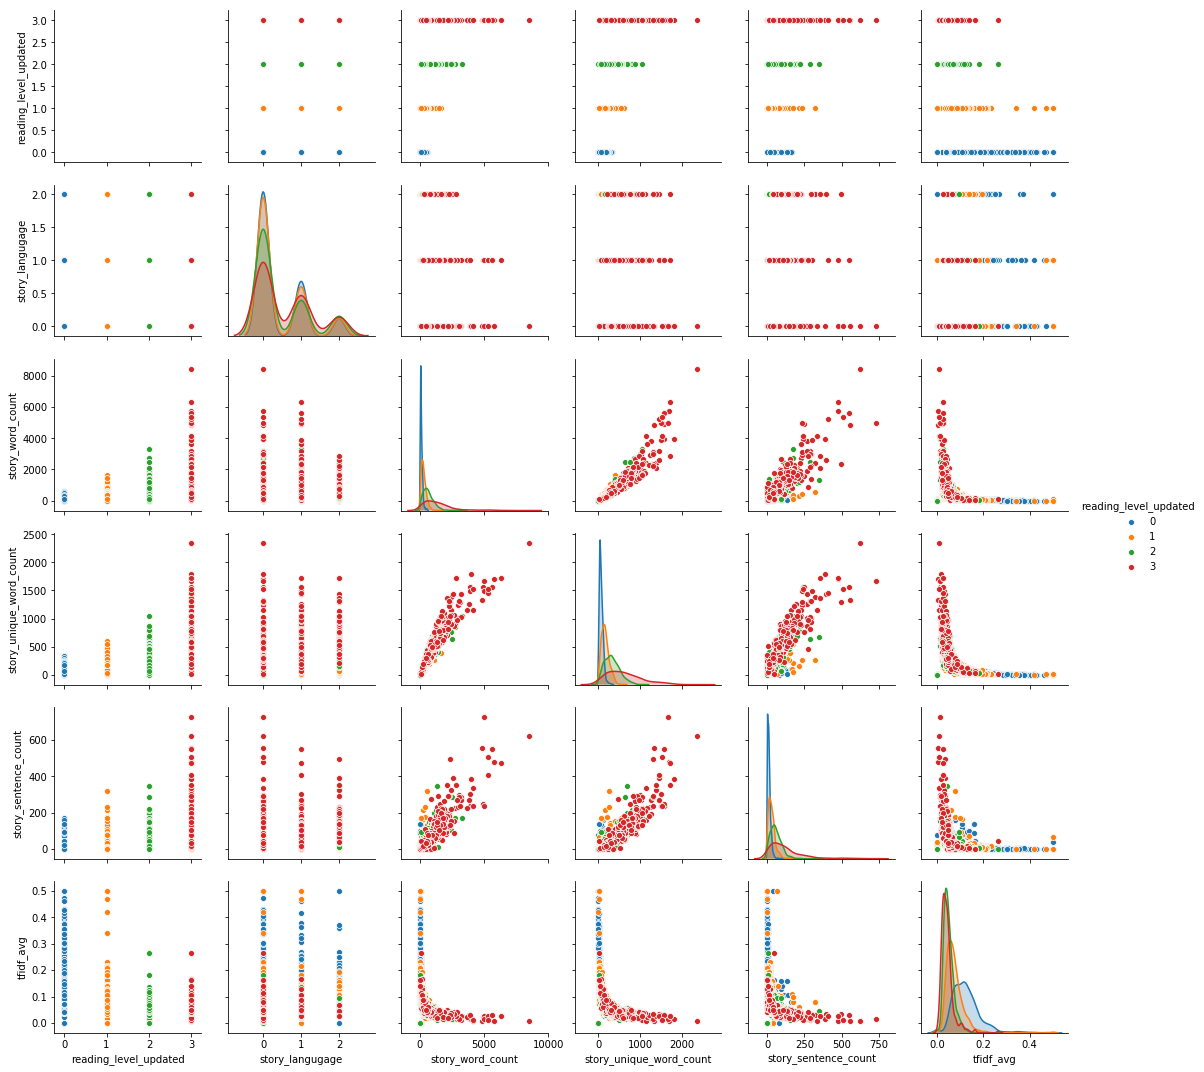

In [26]:
sns.pairplot(data, hue='reading_level_updated')

From the plot we can see that the tfidf_avg is really clumped up for reading levels L3 and L4. This could be an issue caused by larger no. of words in the higher reading levels. We need to find a way to normalize this to get better results. <br>

Lets go forward and train the classifier and see how it performs initially for these features.

English k-fold prediction accuracy:  [0.58627859 0.62785863 0.56784969 0.56066946 0.56184486]


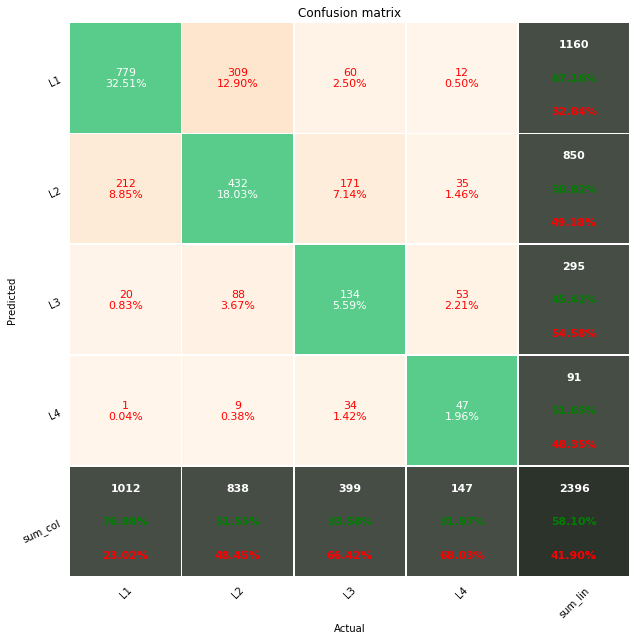

Hindi k-fold prediction accuracy:  [0.68681319 0.65       0.64444444 0.63888889 0.7150838 ]


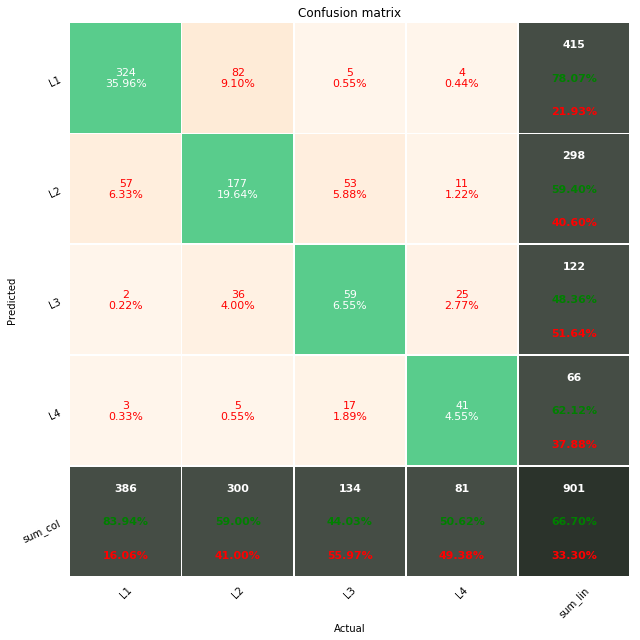

Telugu k-fold prediction accuracy:  [0.68571429 0.6        0.66666667 0.71641791 0.73134328]


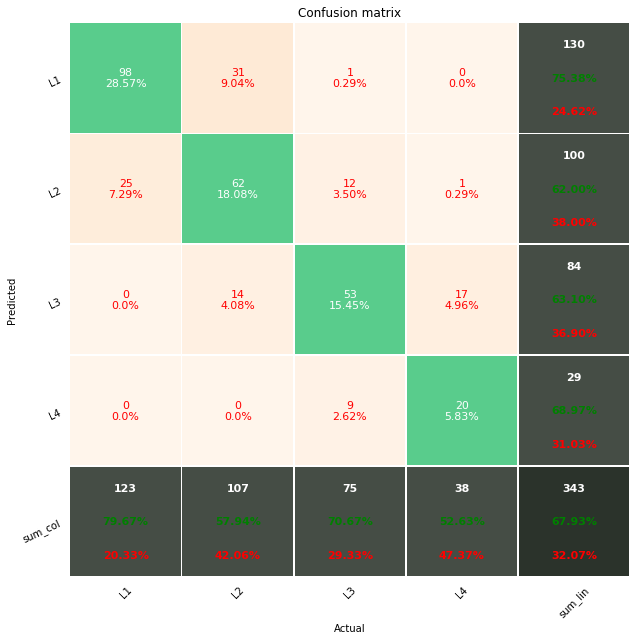

In [27]:
features = ['story_sentence_count', 'story_word_count', 'story_unique_word_count', 'tfidf_avg']
labels = ['reading_level_updated']

rfc = RandomForestClassifier(n_estimators=15, random_state=1)

for key,value in story_language.items():
    X = data[data['story_langugage'] == key][features]
    y = data[data['story_langugage'] == key][labels].values.reshape(-1,1).ravel()
    cv_accuracies = cross_val_score(estimator=rfc, X=X, y=y, cv=5)
    cv_predictions = cross_val_predict(estimator=rfc, X=X, y=y, cv=5)
    print("{0} k-fold prediction accuracy: ".format(value), cv_accuracies)
    plot_confusion_matrix_from_data(y, cv_predictions, columns = ['L1', 'L2', 'L3', 'L4'])

The result is not highly postive. From the confusion matrix we can see that classification in English language had the worst performance, across all the levels. For Hindi and Telugu, classification across some levels are much better than the rest. This could mean that the features we have describes the data effectively for those reading levels and we need to understand more about the higher reading levels. Based on our previous observation of TF-IDF being skewed for higher reading levels, we can experiment with just IDF and see how it performs. We can also try to characterize how frequently is a topic repeated in the story. For lower reading levels, the topics are more frequently repeated to familiarize the reader and to make it stick. The topic frequency should decrease as reading level increses.

Lets talk about language specific features now:
<ul>
    <li><a href="https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests">Flesch kincaid reading grade</a>: This formula outputs a score for reading ease, or output the grade level of a given english text. It is based on no. of words, no. of sentences and total syllables in the text.</li>
    <li>POS tagging: We can study how the use of parts of speech changes in reading levels. My hypothesis being that the detailed explanatory content present in higher reading levels would mean more adjectives, adverbs and preposition.</li>
    <li>Sentiment analysis: Going from my observation, for beginner reading levels the content has a very specific intent. This intent can be thought of as a highly polar content i.e. very happy or very sad for example. Sentiment analysis across the languages and reading levels could provide enough data to differentiate them.</li>
</ul>